In [3]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn import tree

In [4]:
df = pd.read_csv('combined_features.csv')
df

,time,vwap,SMA(5),SMA(10),12dayEWM,rsi,MACD,mom,mfi,spread
0,2021-10-04 08:00:00,1.659676,4.768259,4.786339,4.771101,1.107056,0.867368,0.543952,43.744151,102.684738
1,2021-10-04 09:00:00,1.659675,4.766889,4.776943,4.769641,1.032303,0.822687,0.844880,42.875897,102.612395
2,2021-10-04 10:00:00,1.660783,4.769485,4.775439,4.779400,1.121594,0.918496,2.310488,42.838238,104.369796
3,2021-10-04 11:00:00,1.664391,4.774242,4.771703,4.777858,1.000573,0.913061,0.528564,24.307401,103.491902
4,2021-10-04 12:00:00,1.664180,4.777072,4.769049,4.770852,0.963529,0.904516,0.586155,11.604788,103.568593
...,...,...,...,...,...,...,...,...,...,...
2789,2022-09-23 13:00:00,1.579399,4.908354,4.900728,4.905692,1.341466,-0.357752,-2.098000,-26.144407,97.885000
2790,2022-09-23 14:00:00,1.579414,4.905133,4.904967,4.903628,1.290696,-0.426738,-2.333600,-34.984305,97.701400
2791,2022-09-23 15:00:00,1.579429,4.894920,4.903911,4.890514,1.061713,-0.552944,-3.514100,-43.456076,96.735900
2792,2022-09-23 16:00:00,1.579460,4.882692,4.900211,4.873021,0.829592,-0.594141,-2.135000,-22.911079,97.380000


In [8]:
#generate label for training
import numpy as np
def gen_labels(df,t,threshold):
    # Calculate % return on spread t hours later
    df['forward_return'] = df['spread'].diff(periods=t)/df['spread']
    
    #If the return is more than x%, we should have bought, and hence the label is (1)
    #If return is less than x%, we should have sold, and hence label is (-1)
    #If in between, do nothing (0)
    df['output'] = np.select([df['forward_return'] > threshold ,df['forward_return'] < -threshold],[1,-1])
    return df

df = gen_labels(df,t=24,threshold=0.02)
df

,time,vwap,SMA(5),SMA(10),12dayEWM,rsi,MACD,mom,mfi,spread,forward_return,output
0,2021-10-04 08:00:00,1.659676,4.768259,4.786339,4.771101,1.107056,0.867368,0.543952,43.744151,102.684738,NaN,0
1,2021-10-04 09:00:00,1.659675,4.766889,4.776943,4.769641,1.032303,0.822687,0.844880,42.875897,102.612395,NaN,0
2,2021-10-04 10:00:00,1.660783,4.769485,4.775439,4.779400,1.121594,0.918496,2.310488,42.838238,104.369796,NaN,0
3,2021-10-04 11:00:00,1.664391,4.774242,4.771703,4.777858,1.000573,0.913061,0.528564,24.307401,103.491902,NaN,0
4,2021-10-04 12:00:00,1.664180,4.777072,4.769049,4.770852,0.963529,0.904516,0.586155,11.604788,103.568593,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2789,2022-09-23 13:00:00,1.579399,4.908354,4.900728,4.905692,1.341466,-0.357752,-2.098000,-26.144407,97.885000,-0.028656,-1
2790,2022-09-23 14:00:00,1.579414,4.905133,4.904967,4.903628,1.290696,-0.426738,-2.333600,-34.984305,97.701400,-0.033097,-1
2791,2022-09-23 15:00:00,1.579429,4.894920,4.903911,4.890514,1.061713,-0.552944,-3.514100,-43.456076,96.735900,-0.040152,-1
2792,2022-09-23 16:00:00,1.579460,4.882692,4.900211,4.873021,0.829592,-0.594141,-2.135000,-22.911079,97.380000,-0.034042,-1


In [9]:
#train and test data
split = round(0.8*len(df))
train, test = df[:split],df[split:]
x_train = train[['vwap','SMA(5)','SMA(10)','12dayEWM','rsi','MACD','mom','mfi','spread']]
y_train = train[['output']]

x_test = test[['vwap','SMA(5)','SMA(10)','12dayEWM','rsi','MACD','mom','mfi','spread']]
y_test = test[['output']]

In [11]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100, 120],
    'max_features': [9],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

# Instantiate the grid search model
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# model = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

<ipython-input-11-0e7ce4f388a4>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train,y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  9.6min finished
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 200}

In [12]:
rf_model = RandomForestClassifier(bootstrap= True,
                             max_depth= 100,
                             max_features= 9,
                             min_samples_leaf= 5,
                             min_samples_split= 8,
                             n_estimators=200,
                             random_state = 42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

<ipython-input-12-2ceee20fe240>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(x_train, y_train)


In [13]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

          -1       0.89      0.90      0.89       103
           0       0.87      0.94      0.90       380
           1       0.74      0.46      0.57        76

    accuracy                           0.87       559
   macro avg       0.84      0.77      0.79       559
weighted avg       0.86      0.87      0.86       559



[Text(1121.9869492337166, 2352.4210526315787, 'MACD <= -0.33\ngini = 0.568\nsamples = 1436\nvalue = [443, 1318, 474]\nclass = 0'),
 Text(413.33333333333337, 2225.2631578947367, 'rsi <= 0.889\ngini = 0.393\nsamples = 310\nvalue = [372, 137, 0]\nclass = 1'),
 Text(190.03831417624522, 2098.1052631578946, 'vwap <= 1.562\ngini = 0.298\nsamples = 235\nvalue = [310, 69, 0]\nclass = 1'),
 Text(171.0344827586207, 1970.9473684210525, 'gini = 0.375\nsamples = 9\nvalue = [4, 12, 0]\nclass = 0'),
 Text(209.04214559386975, 1970.9473684210525, 'mom <= -1.553\ngini = 0.265\nsamples = 226\nvalue = [306, 57, 0]\nclass = 1'),
 Text(95.01915708812261, 1843.7894736842104, 'MACD <= -0.479\ngini = 0.1\nsamples = 98\nvalue = [143, 8, 0]\nclass = 1'),
 Text(38.00766283524904, 1716.6315789473683, 'spread <= 92.731\ngini = 0.033\nsamples = 77\nvalue = [117, 2, 0]\nclass = 1'),
 Text(19.00383141762452, 1589.4736842105262, 'gini = 0.0\nsamples = 52\nvalue = [84, 0, 0]\nclass = 1'),
 Text(57.01149425287356, 1589.47

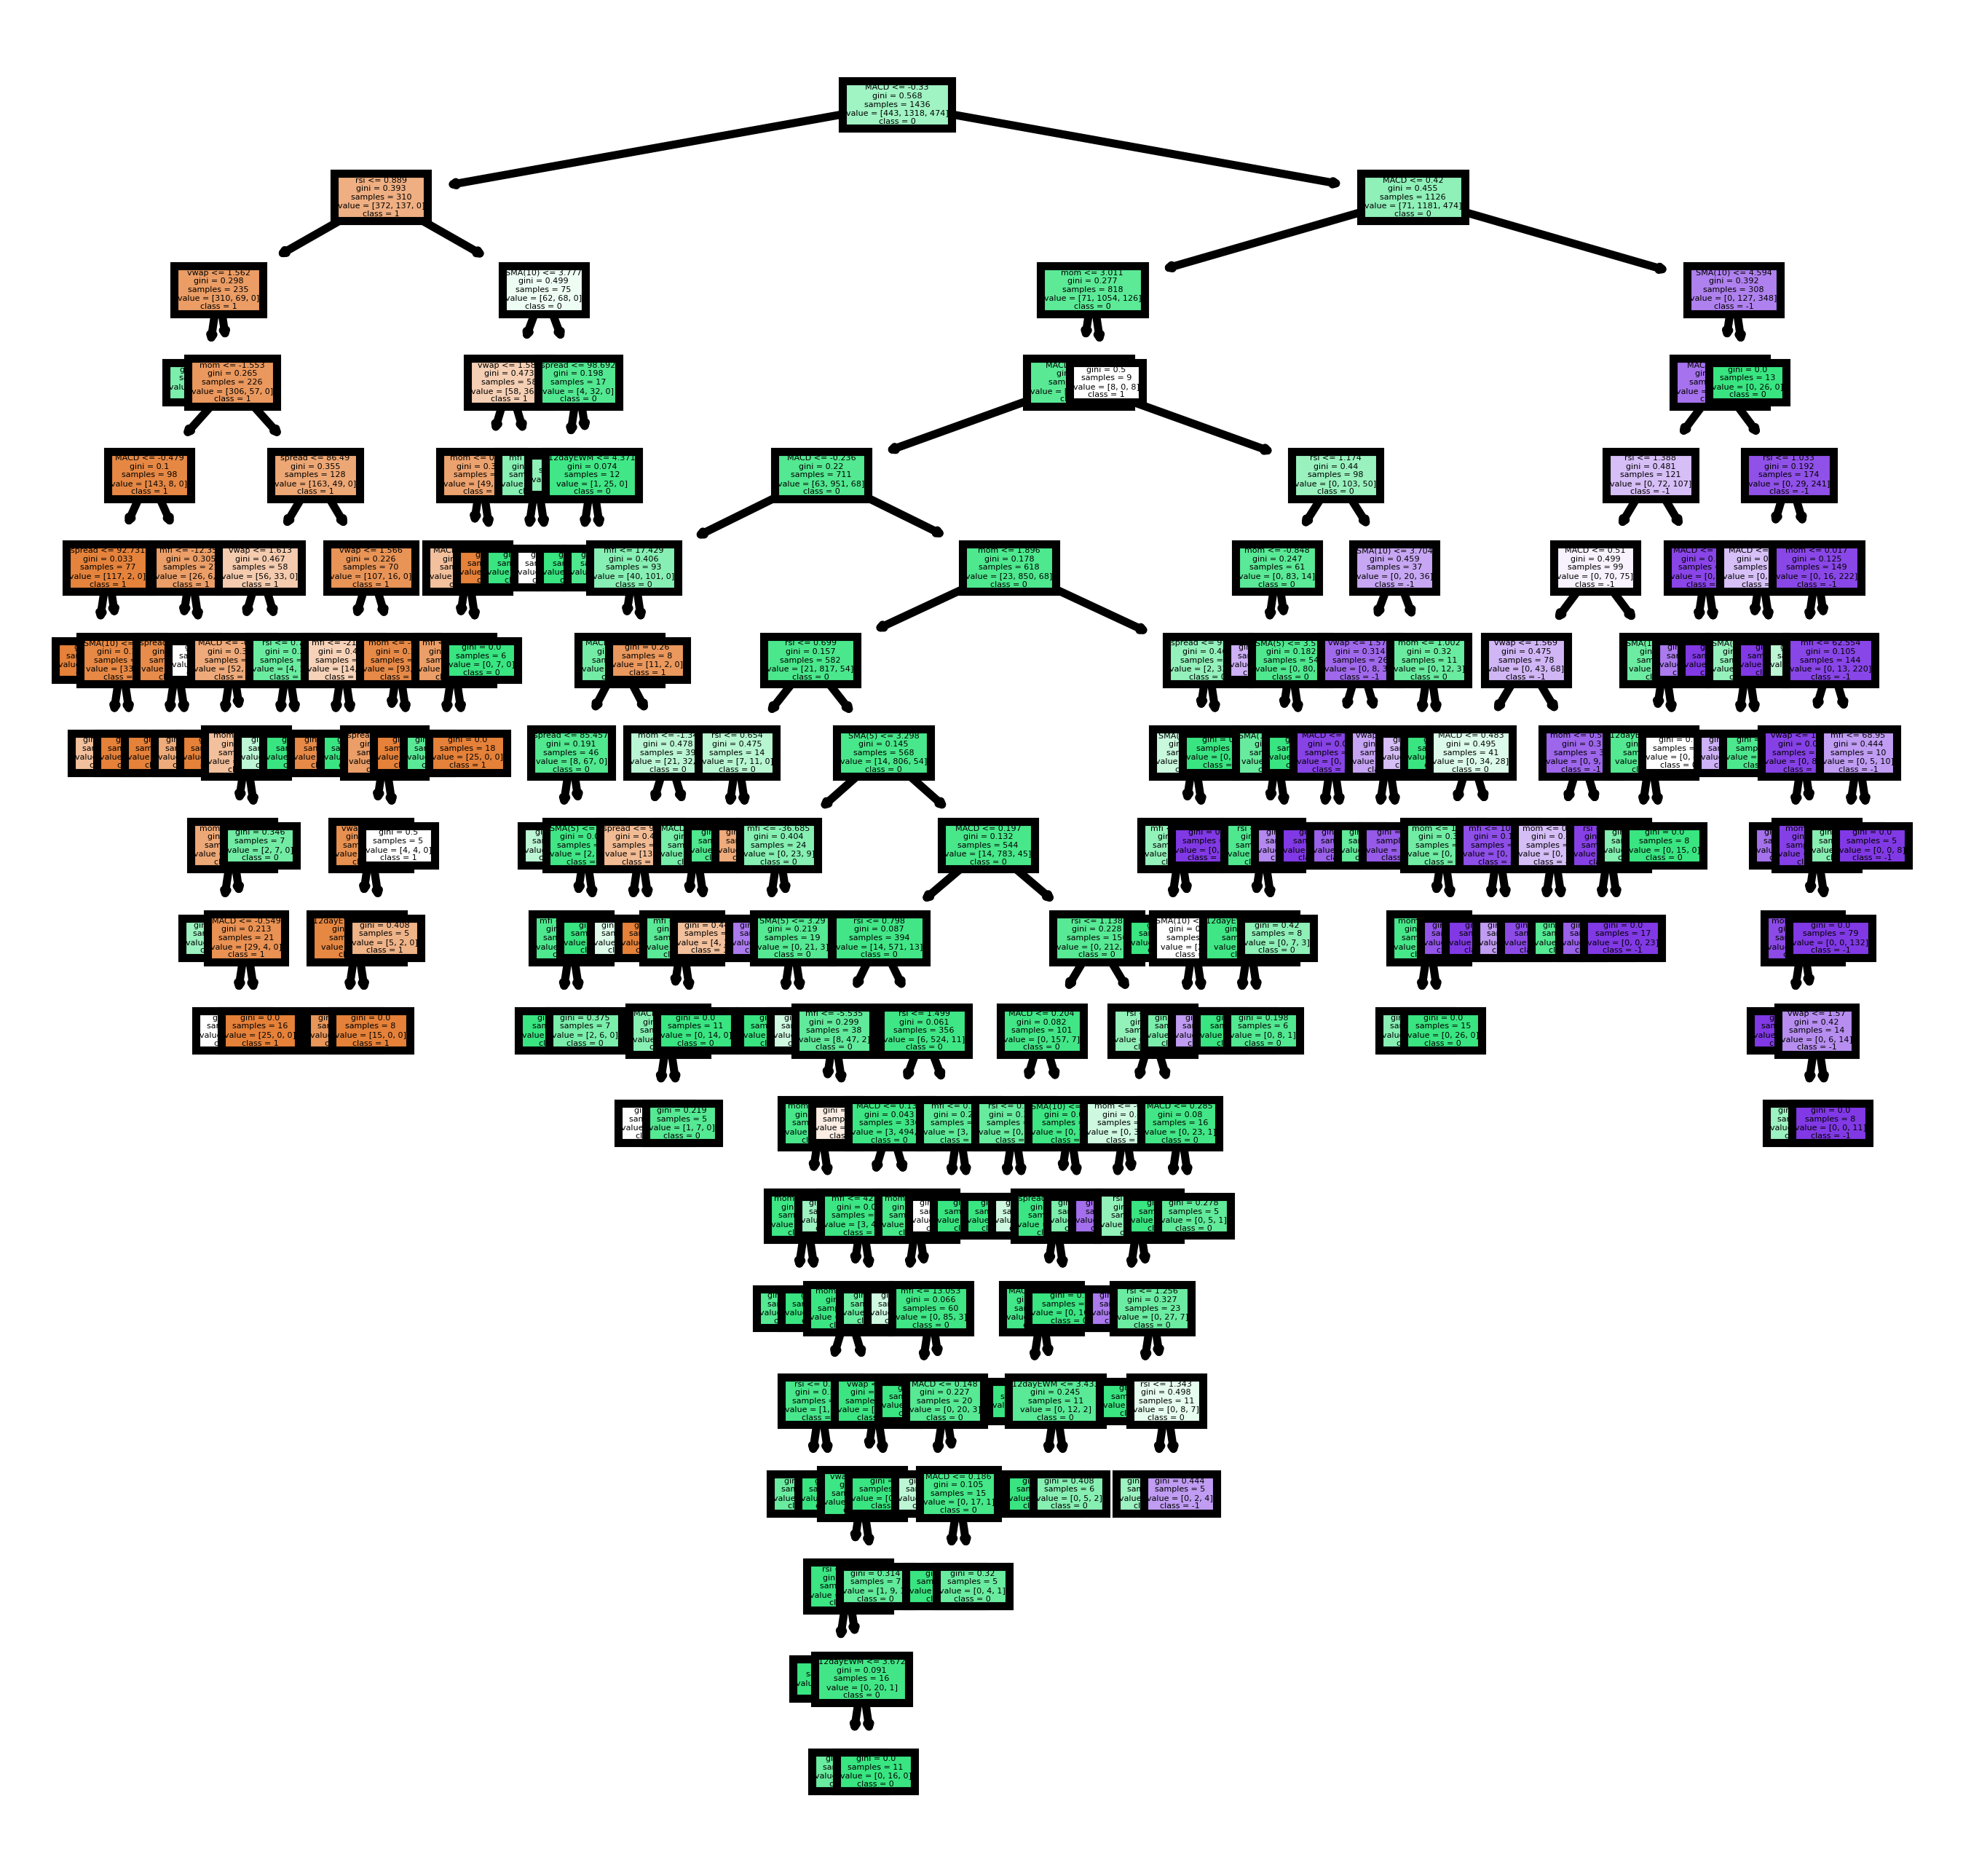

In [14]:
fn = ['vwap','SMA(5)','SMA(10)','12dayEWM','rsi','MACD','mom','mfi','spread']
cn = ['1','0','-1']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_model.estimators_[0],
               feature_names = fn, 
               class_names = cn,
               filled = True)